In [1]:
import cedalion
import cedalion.nirs
import cedalion.glm.design_matrix as cd_dm
import cedalion.glm.solve as cd_glm
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt

xr.set_options(display_expand_data=False)

# Define Parameters

In [2]:
# relative HRF start and end times
HRF_tmin = -2
HRF_tmax = 15

# remove first 20 seconds of data (motion artefacts)
omsec = 20

# subject list
subjects = [86, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]

In [3]:
DATADIR = "/home/thomas/Dokumente/SHK/Data/RESTING_DATA"

# Load Data

In [4]:
# store data of different subjects in a dictionary
data = {}
#for subject in subjects:
for sbj in subjects:

    elements = cedalion.io.read_snirf(
        os.path.join(DATADIR, f"Subj{sbj}/resting_sim_100_shorterHRF.snirf")
    )

    amp = elements[0].data[0]
    # work around missing units in snirf file
    amp = amp.pint.dequantify().pint.quantify("volts")

    stim = elements[0].stim # pandas Dataframe
    geo3d = elements[0].geo3d

    stim.cd.rename_events( {
        "1" : "Stim",
        "2" : "Rest",
    })


    # remove unused stims
    stim = stim.loc[stim.onset>=omsec]
    # if first trial is of cond rest, then remove this trial
    if stim.onset.min() == stim.onset[stim.trial_type == "Rest"].min():
        stim = stim.loc[stim.onset > stim.onset.min()]

    # if last trial is of cond stim, then remove this trial
    if stim.onset.max() == stim.onset[stim.trial_type == "Stim"].max():
        stim = stim.loc[stim.onset < stim.onset.max()]

    dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength" : amp.wavelength}
    )

    od = - np.log( np.abs(amp / amp.mean("time")) )

    od_filtered = od.cd.freq_filter(0, 0.5, 6)

    conc = cedalion.nirs.beer_lambert(od_filtered, geo3d, dpf, calc_od=False)

    conc = conc.transpose("time", "chromo", "channel")

    # create stimulus array
    stim_arr = stim.cd.to_xarray(amp.time)

    data[sbj] = xr.Dataset(
        data_vars = {
            "amp" : amp,
            "geo" : geo3d,
            "od"  : od,
            "conc": conc,
            "stim": stim_arr
        },
        attrs={"stim" : stim}, # store stimulus data in attrs
        coords={"sbj" : sbj} # add the subject label as a coordinate
    )

    data[sbj] = data[sbj].sel(time = amp.time >= omsec)


# Select Example Subject

In [5]:
sbj = 91
conc = data[sbj].data_vars["conc"]
stim = data[sbj].attrs["stim"]
geo3d = data[sbj].data_vars["geo"]

In [6]:
data[sbj]

Magnitude,[[[256051.50361324925 255726.63481434667 255902.23026839588 ... 243239.5790901834 243264.3517123831 244065.845434679] [990342.1552873456 988661.6672112431 988249.0985826844 ... 956387.019011699 957387.8524134714 961615.9726517011]] [[72678.59678408109 73027.42632027487 73105.99566549876 ... 69434.40581191909 69366.02735572573 68978.54616396713] [772055.1047212922 772118.6091488638 772114.4635250617 ... 775844.3228901176 775297.3789741452 775945.1566538046]] [[287037.58464247885 286398.7513090451 285981.44073963386 ... 277956.1236034214 278266.6461359117 278775.67263581225] [330338.9834415473 329382.11472155456 329036.63558704307 ... 329941.95109221846 330155.04100150085 331210.06853599794]] ... [[82551.09764871045 87056.58886911743 85693.91504463342 ... 104091.67253624133 122824.37954192275 127746.42126427524] [1432305.7366608067 1423765.064664496 1419585.8983679635 ... 1394833.1283067844 1383338.5293615558 1385450.4924636937]] [[2323.766980663172 2936.940369274909 2421.9756854976667 ... 2091.3226831335264 4043.459834660632 4477.954059145955] [6766.099714114342 7694.959443960828 8489.709875450064 ... 4701.911394564977 4999.116951778669 6386.645613245038]] [[84059.02833160968 76489.66804700423 80277.58495495032 ... 131407.30521224567 154032.83186264778 173500.52536031563] [1094250.6677281766 1070999.1581910066 1061041.7774149626 ... 1038272.6923414546 1039395.0536582654 1048096.1259767533]]]
Units,volt
Magnitude,[[-30.0 0.0 0.0] [0.0 0.0 0.0] [30.0 0.0 0.0] [52.0 0.0 0.0] [74.0 0.0 0.0] [100.0 0.0 0.0] [130.0 0.0 0.0] [160.0 0.0 0.0] [-120.0 0.0 0.0] [-150.0 0.0 0.0] [-180.0 0.0 0.0] [-202.0 0.0 0.0] [-224.0 0.0 0.0] [-250.0 0.0 0.0] [-280.0 0.0 0.0] [-310.0 0.0 0.0] [-15.0 -26.0 0.0] [15.0 -26.0 0.0] [41.0 -28.0 0.0] [63.0 -28.0 0.0] [0.0 8.0 0.0] [52.0 8.0 0.0] [-15.0 26.0 0.0] [15.0 26.0 0.0] [41.0 28.0 0.0] [63.0 28.0 0.0] [115.0 -26.0 0.0] [145.0 -26.0 0.0] [100.0 8.0 0.0] [160.0 8.0 0.0] [115.0 26.0 0.0] [145.0 26.0 0.0] [-135.0 -26.0 0.0] [-165.0 -26.0 0.0] [-191.0 -28.0 0.0] [-214.0 -28.0 0.0] [-150.0 8.0 0.0] [-202.0 8.0 0.0] [-135.0 26.0 0.0] [-165.0 26.0 0.0] [-191.0 28.0 0.0] [-214.0 28.0 0.0] [-265.0 -26.0 0.0] [-295.0 -26.0 0.0] [-250.0 8.0 0.0] [-310.0 8.0 0.0] [-265.0 26.0 0.0] [-295.0 26.0 0.0]]
Units,millimeter
Magnitude,[[[-0.08703190804484504 -0.08576233899472442 -0.08644875632934995 ... -0.035700177631530376 -0.035802016982263825 -0.03909134503805302] [-0.15029372136684643 -0.14859540379826514 -0.14817801658819293 ... -0.11540588927810763 -0.11645181532505863 -0.12085840068440265]] [[-0.058661667684268906 -0.06344980471810935 -0.06452511455109605 ... -0.012997236753507583 -0.012011959400051193 -0.006410262201074163] [-0.036349757298128796 -0.036432007665476954 -0.03642663849695505 ... -0.04124571587311542 -0.040540501207063075 -0.04137567391853078]] [[-0.047873297237793495 -0.04564520823238358 -0.0441870493053284 ... -0.015723405579544696 -0.016839945863918824 -0.01866755078523946] [-0.09364671958269519 -0.0907458895390712 -0.0896964687379307 ... -0.0924441030102175 -0.09308973514984749 -0.0962801920221889]] ... [[0.05368008983914123 0.0005392029138468195 0.016315736787949956 ... -0.17817442068129835 -0.3436579695890797 -0.38294965821345955] [0.0042259511169106204 0.010206683422323701 0.013146291905637274 ... 0.03073671328886834 0.0390116983891185 0.03748614805278851]] [[0.13062943128000123 -0.10354934998659256 0.08923539268438668 ... 0.23602227019973346 -0.4232817214477179 -0.525347260142409] [0.08491055474152774 -0.043730134317083176 -0.1420194647169931 ... 0.44886625678051734 0.3875740753269178 0.14262617511502543]] [[0.0797847729462278 0.17414836972992756 0.12581360252991397 ... -0.3669976564955813 -0.5258617303721921 -0.6448765841635344] [-0.041416798672579476 -0.01993899683102858 -0.010598225734090545 ... 0.011094549005019192 0.010014143893906362 0.001677703678689029]]]
Units,dimensionless
Magnitude,[[[-3.5320378003833675 -0.5334859293332559 -2.3662942790161763 ... -0.0971391683621617 -10.89

# Build design matrix

## HRF Regressors

In [7]:
# get design matrices
dm_gaussians = cd_dm.make_design_matrix(conc.time, stim, [-2, 15], "gaussians", [0.5, 0.5])

dm_gamma = cd_dm.make_design_matrix(conc.time, stim, [0, 15], "gamma", [1, 1, 10])

dm_gamma_deriv = cd_dm.make_design_matrix(conc.time, stim, [0, 15], "gamma_deriv", [1, 1, 10])

dm_afni_gamma = cd_dm.make_design_matrix(conc.time, stim, [0, 15], "afni_gamma", [8, 0.5, 8])

dm_matrices = {
    "gaussians" : dm_gaussians,
    "gamma" : dm_gamma,
    "gamma_deriv" : dm_gamma_deriv,
    "afni_gamma" : dm_afni_gamma
}


In [8]:
# select time of first trial of condition stim
t0 = stim.onset[stim.trial_type == "Stim"].min()

# select time of first trial of condition rest
t1 = stim.onset[stim.trial_type == "Rest"].min()

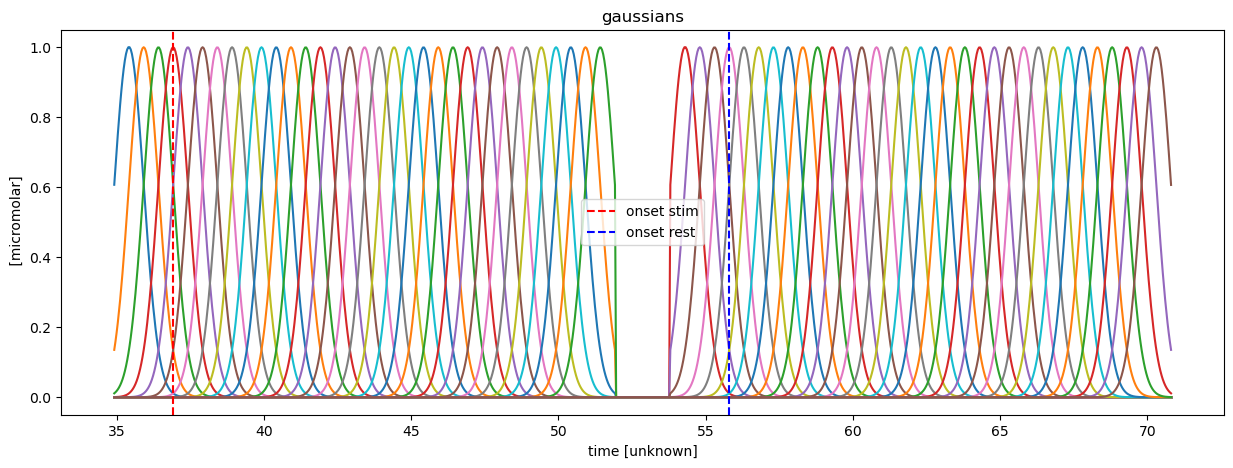

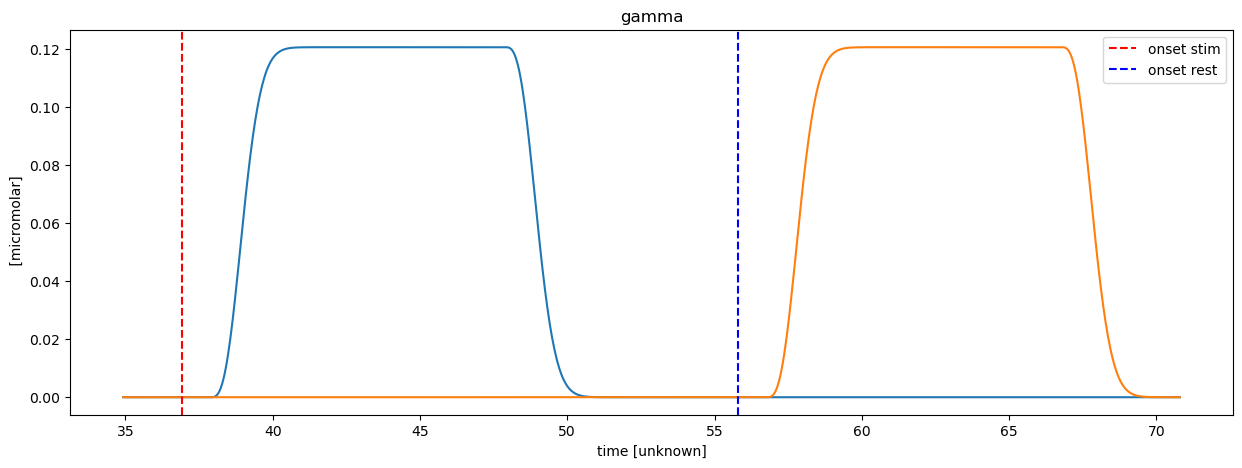

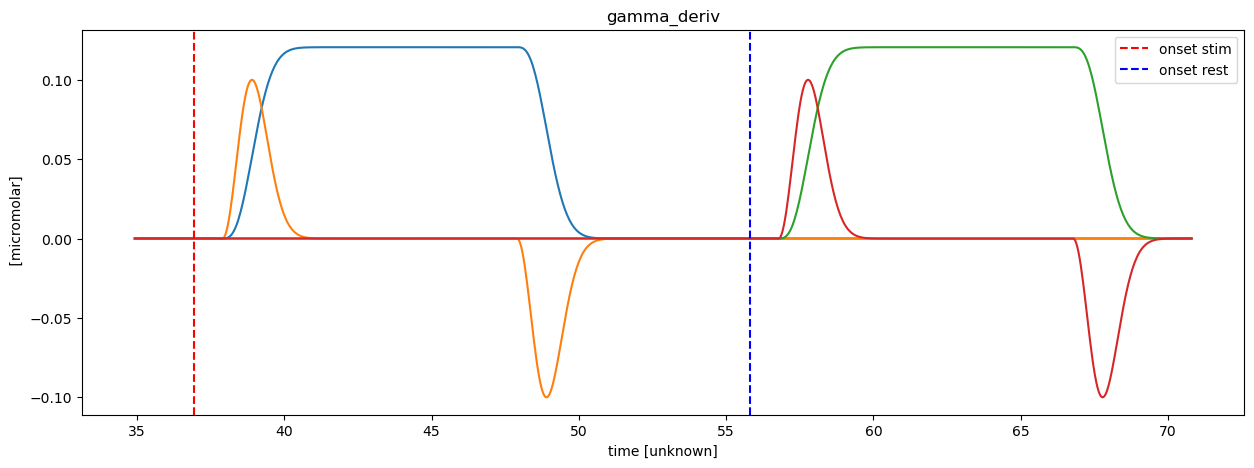

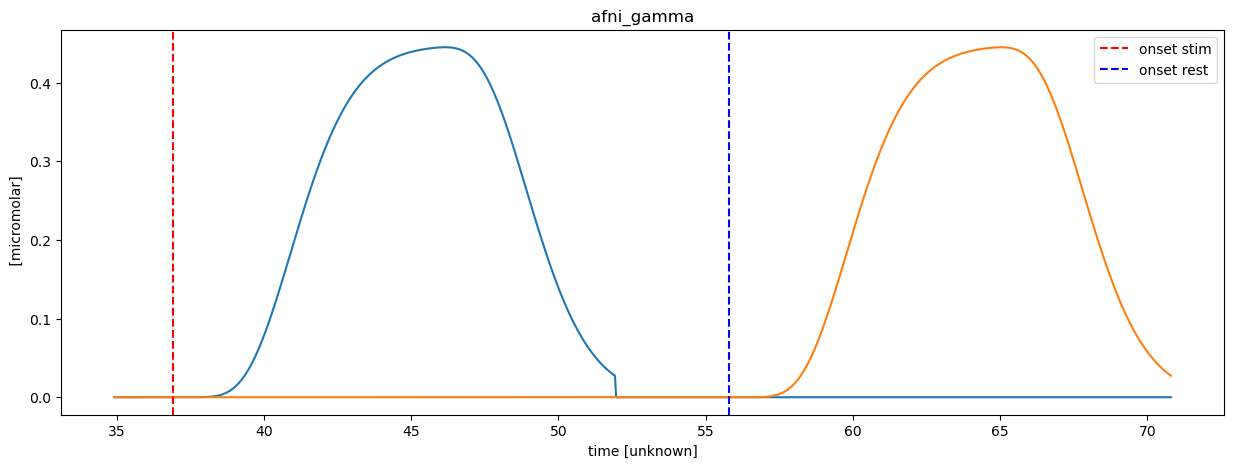

In [9]:
plt.rcParams['figure.figsize'] = [15, 5]
for dm_name, dm in dm_matrices.items():
    time_slice = dm.time.sel(time=slice(t0 + HRF_tmin, t1 + HRF_tmax))
    for regressor in dm.regressor.values:
        if "HRF" in regressor:
            dm.sel(
                chromo='HbO',
                regressor=regressor,
                time=time_slice
            ).plot()

    plt.title(dm_name)
    plt.axvline(x=t0, color="red", linestyle="--", label="onset stim")
    plt.axvline(x=t1, color="blue", linestyle="--", label="onset rest")
    plt.legend()

    plt.show()

## Drift and additional regressors

In [10]:
# generate random xarray dataarray with additional regressors
n_add_regs = 5
add_regs = xr.DataArray(
    np.random.rand(conc.time.size, n_add_regs, 2),
    dims=["time", "regressor", "chromo"],
    coords={"time" : conc.time,
            "regressor" : [f"add_reg_{i}" for i in range(n_add_regs)],
            "chromo" : ["HbO", "HbR"]}
)
print(add_regs)
add_regs = add_regs.pint.quantify("micromolar")

<xarray.DataArray (time: 15550, regressor: 5, chromo: 2)>
0.1357 0.009291 0.6357 0.5484 0.5449 0.9153 ... 0.0117 0.7802 0.1433 0.28 0.7175
Coordinates:
  * time       (time) float64 20.0 20.04 20.08 20.12 ... 641.8 641.9 641.9 642.0
  * regressor  (regressor) <U9 'add_reg_0' 'add_reg_1' ... 'add_reg_4'
  * chromo     (chromo) <U3 'HbO' 'HbR'


In [17]:
dm_gaussians = cd_dm.make_design_matrix(conc.time, stim, [-2, 15], "gaussians", [0.5, 0.5], 2, add_regs)
# or you can just append add_regs to the design matrix
# by concatenating the xarrays on the regressor dimension
#dm_gaussians = xr.concat([dm_gaussians, add_regs], dim="regressor")

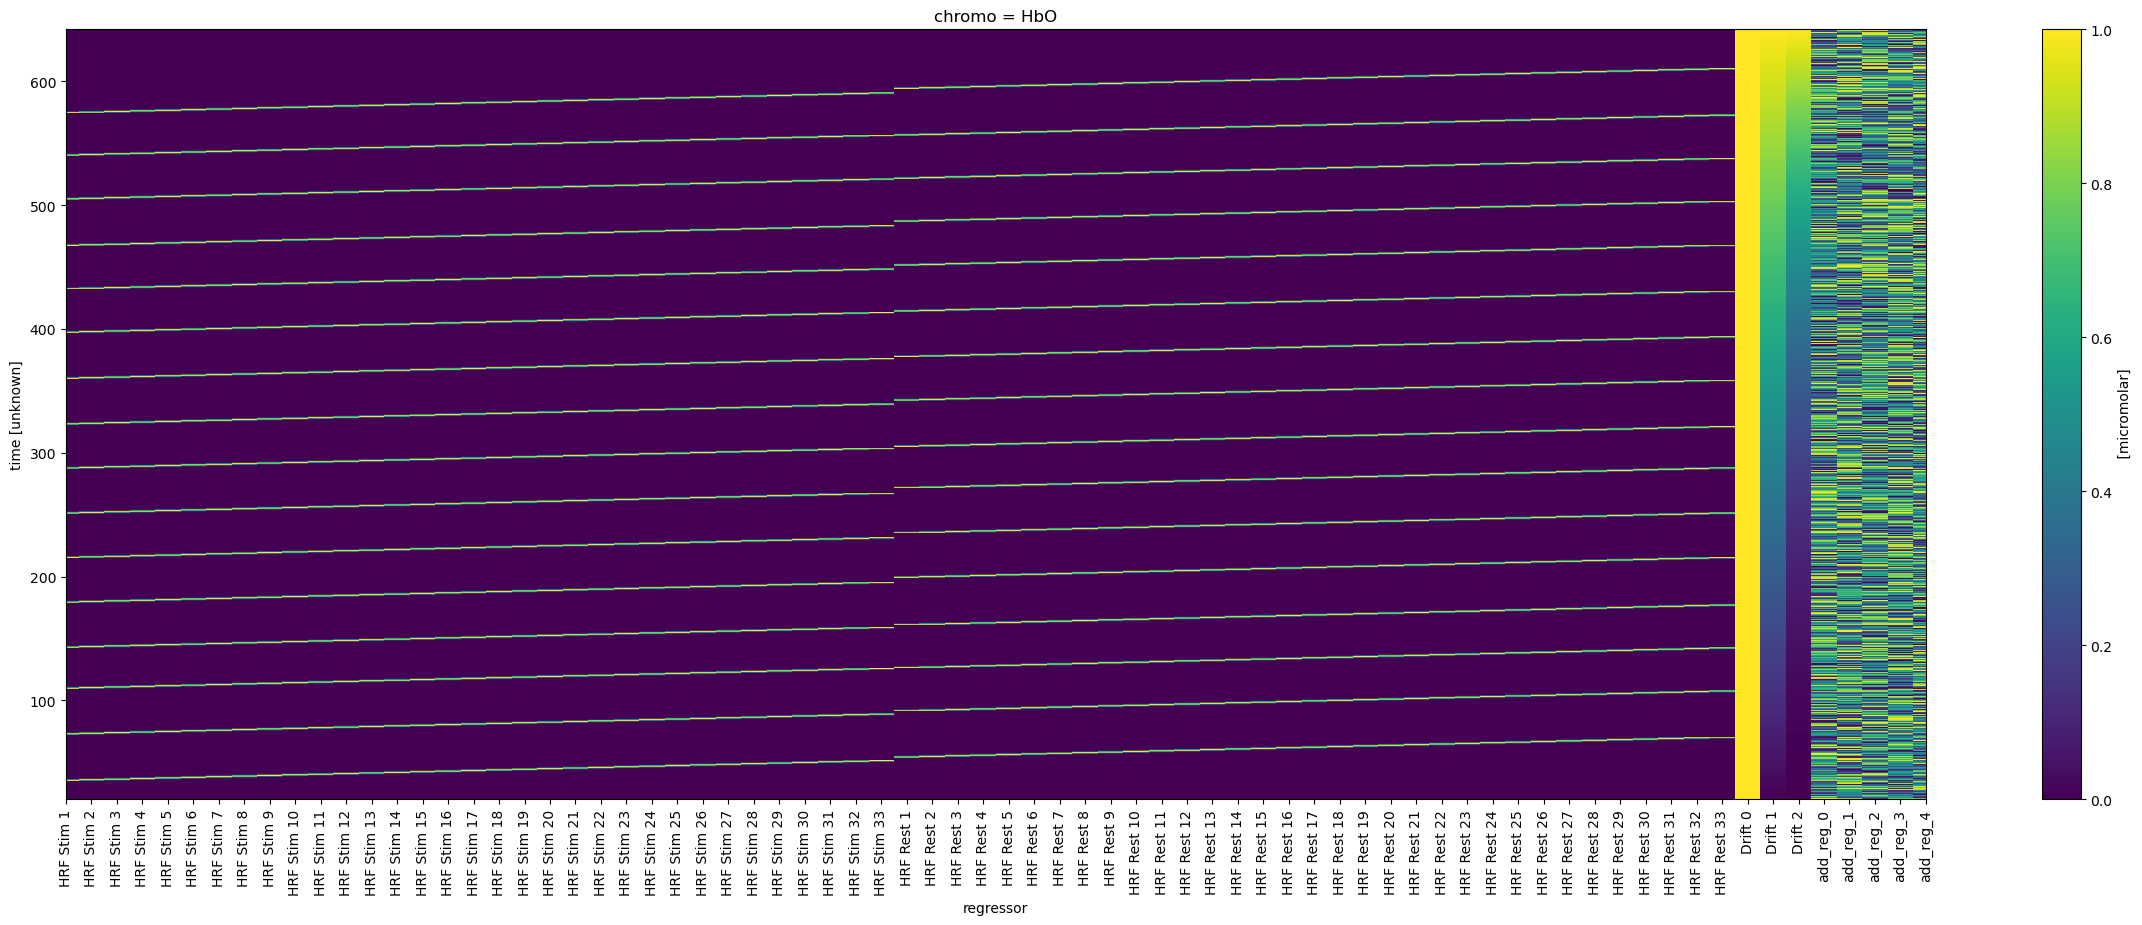

In [18]:
# plot design matrix
plt.rcParams['figure.figsize'] = [30, 10]
dm_gaussians.sel(chromo="HbO").plot()
plt.xticks(rotation=90)
plt.show()